In [7]:
import gc

gc.collect()

1003

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

from sktime.transformations.series.adapt import PandasTransformAdaptor
from sktime.utils import plotting
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.croston import Croston
from sktime.datasets import load_PBS_dataset
from sktime.forecasting.arima import AutoARIMA
from sktime.datatypes import get_examples
from sktime.datatypes import check_raise
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer
from sktime.transformations.compose import InvertTransform
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.acf import AutoCorrelationTransformer
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from statsmodels.tsa.stattools import adfuller
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
import time
import csv
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

tf.keras.backend.clear_session()
tf.compat.v1.disable_eager_execution() #IF ERROR, UNCOMMENT
# Any results you write to the current directory are saved as output.

timestamp_Frequency = ['Weekly'] #'month'
if timestamp_Frequency[0] == 'Weekly':
    season_number_of_points = 52
    forecastingHorizon = 26
else:
    season_number_of_points = 12
    forecastingHorizon = 6
patience = 25

sp = season_number_of_points
timestamp = season_number_of_points
train_ratio = 0.5
if train_ratio < 0.5 :
    train_ratio = 0.5
usePipe = True #False is currently broken
useValidation = True
progressiveForecast = False
saveModel = False
loadModel = True
productionMode = True
exportResults = True
outputDirectory = "/home/esteban/Documents/Optimix/Projet_LSTM_Keras_C++/results/"
# productionMode = True

# datasetList = ['AirPassengers.csv','AirPassengers.csv']
# datasetList = ["12141","18805","25472","26855","72758","90833","197456","566393"]
#"74826" 
datasetList = ["75038","85843","85861","86040","86543","121216","121397","121457","197456","253059","268987","269221","271177",
"271179","370801","417538","417622","424390","424391","424479","534571","545488","546924","566393","566394","566395", "566409"]
# datasetList = ["417538"]


if (progressiveForecast):
    indirectForecastingHorizon = forecastingHorizon
    forecastingHorizon = 1
    realForecastingHorizon = indirectForecastingHorizon
else:
    realForecastingHorizon = forecastingHorizon

In [10]:
start_bloc_1 = time.time()
if (usePipe):
    print(len(datasetList))
    pipeTrain = list([])
    pipeTest = list([])
    #DO NOT TOUCH PIPELINES DELCARATION WITHOUT A VERY GOOD REASON !!!!!!! OR WEIRD BEHAVIOUR IS TE BE EXPECTED
    for i in range (len(datasetList)):
        pipeTrain.append(TransformerPipeline(steps=[
            ("imputer", Imputer(method="mean")),
            ("boxcox", BoxCoxTransformer()),
            ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
#             ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
#             ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#             ("differencer", Differencer(lags=1, na_handling='fill_zero')),
#             ("differencer", Differencer(lags=12, na_handling='fill_zero')),
#             ("forecaster", NaiveForecaster(strategy="drift")),
        ]))
        pipeTest.append(TransformerPipeline(steps=[
            ("imputer", Imputer(method="mean")),
            ("boxcox", BoxCoxTransformer()),
            ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
#             ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
#             ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#             ("differencer", Differencer(lags=1, na_handling='fill_zero')),
#             ("differencer", Differencer(lags=12, na_handling='fill_zero')),
#             ("forecaster", NaiveForecaster(strategy="drift")),
        ]))
else :
    scalerTrain = list([])
    scalerTest = list([])
    for i in range (len(datasetList)):
        scalerTrain.append(MinMaxScaler(feature_range=(0,1)))
        scalerTest.append(MinMaxScaler(feature_range=(0,1)))
duration_bloc_1 = time.time() - start_bloc_1

27


In [11]:

start_bloc_2 = time.time()
trainDatasetArray = list([])
testDatasetArray = list([])
datasetArray = list([])
lastTimestampArray = list([])
for idxdataset, datasetName in enumerate(datasetList):
    datasetTarget="/home/esteban/Documents/Optimix/Projet_LSTM_Keras_C++/Data/correctedsupplyProduct_"+datasetName+".csv"
    df = pd.read_csv(datasetTarget, header=0, index_col=0)
    lastTimestampArray.append(df.index[-1])
    df.reset_index(inplace=True)
    print(df)
    dataset = df.iloc[:,1].values
    # if (datasetName == "566409"):
    #     # print(dataset)
    #     plt.plot(dataset)
    #     plt.show
    if (not (productionMode)):
        train_size = int(len(dataset)*train_ratio)
        test_size = len(dataset) - train_size
        if (train_ratio == 0.5 and train_size != test_size):
            test_size = min(test_size,train_size) 
            train_size = min(test_size,train_size)
        trainDataset = dataset[:train_size]
        testDataset = dataset[train_size:train_size+test_size]
        trainDatasetArray.append(trainDataset)
        len_of_trainDataset = len(trainDataset)-timestamp-forecastingHorizon+1
        len_of_trainDataset_indirect = len(trainDataset)-timestamp-indirectForecastingHorizon+1
    else:
        test_size = len(dataset)
        testDataset = dataset[0:test_size]
        # print("train_size : ",train_size,"test_size : ",test_size)
    datasetArray.append(dataset)
    testDatasetArray.append(testDataset)
    if (not (productionMode)):
        len_of_testDataset = len(testDataset)-timestamp-forecastingHorizon+1
        len_of_testDataset_indirect = len(testDataset)-timestamp-indirectForecastingHorizon+1
    else:
        len_of_testDataset = len(testDataset)-timestamp
        len_of_testDataset_indirect = len(testDataset)-timestamp
    print(len(testDataset) ,timestamp,forecastingHorizon )
    print(len(testDataset),timestamp,indirectForecastingHorizon)
    if (idxdataset == 0):
        # print(len_of_trainDataset, min_len_of_trainDataset, datasetName)
        if (not (productionMode)):
            max_len_of_trainDataset = len_of_trainDataset
            min_len_of_trainDataset = len_of_trainDataset
            max_len_of_trainDataset_indirect = len_of_trainDataset_indirect
            min_len_of_trainDataset_indirect = len_of_trainDataset_indirect
            print("min_len_of_trainDataset ",min_len_of_trainDataset)
            print("max_len_of_trainDataset ",max_len_of_trainDataset)
            print("min_len_of_trainDataset_indirect ",min_len_of_trainDataset_indirect)
            print("max_len_of_trainDataset_indirect ",max_len_of_trainDataset_indirect)
        
        max_len_of_testDataset = len_of_testDataset
        min_len_of_testDataset = len_of_testDataset
        max_len_of_testDataset_indirect = len_of_testDataset_indirect
        min_len_of_testDataset_indirect = len_of_testDataset_indirect


    else:
        if (not (productionMode)):
            if (len_of_trainDataset < min_len_of_trainDataset):
                min_len_of_trainDataset = len_of_trainDataset
            if (len_of_trainDataset > max_len_of_trainDataset):
                max_len_of_trainDataset = len_of_trainDataset
            if (len_of_trainDataset_indirect < min_len_of_trainDataset_indirect):
                min_len_of_trainDataset_indirect = len_of_trainDataset_indirect
            if (len_of_trainDataset_indirect > max_len_of_trainDataset_indirect):
                max_len_of_trainDataset = len_of_trainDataset_indirect
            print("min_len_of_trainDataset ",min_len_of_trainDataset)
            print("max_len_of_trainDataset ",max_len_of_trainDataset)
            print("min_len_of_trainDataset_indirect ",min_len_of_trainDataset_indirect)
            print("max_len_of_trainDataset_indirect ",max_len_of_trainDataset_indirect)
        if (len_of_testDataset < min_len_of_testDataset):
            min_len_of_testDataset = len_of_testDataset
        if (len_of_testDataset > max_len_of_trainDataset):
            max_len_of_testDataset = len_of_testDataset
        if (len_of_testDataset_indirect < min_len_of_testDataset_indirect):
            min_len_of_testDataset_indirect = len_of_testDataset_indirect
        if (len_of_testDataset_indirect > max_len_of_testDataset_indirect):
            max_len_of_testDataset_indirect = len_of_testDataset_indirect
    print("min_len_of_testDataset ",min_len_of_testDataset)
    print("max_len_of_testDataset ",max_len_of_testDataset)
    print("min_len_of_testDataset_indirect ",min_len_of_testDataset_indirect)
    print("max_len_of_testDataset_indirect ",max_len_of_testDataset_indirect)
duration_bloc_2 = time.time() - start_bloc_2 
total_duration = duration_bloc_2 + duration_bloc_1

           Time   salesqty
0    2017-01-02  21.000000
1    2017-01-09  41.000000
2    2017-01-16  20.000000
3    2017-01-23  21.000000
4    2017-01-30  33.390244
..          ...        ...
200  2020-11-02  48.000000
201  2020-11-09  45.000000
202  2020-11-16  29.000000
203  2020-11-23  32.000000
204  2020-11-30  33.390244

[205 rows x 2 columns]
205 52 26


NameError: name 'indirectForecastingHorizon' is not defined

In [12]:
start_bloc_3 = time.time()

def generateXY(transformedDataset,rangeSize,timestamp,forecastingHorizon):
    dataX = []
    dataY = []
    # print(len(transformedTrainDataset),len(transformedTestDataset))
    for i in range(rangeSize):
        a = transformedDataset[i:(i+timestamp),0]
        b = transformedDataset[(i+timestamp):(i+timestamp+forecastingHorizon),0]
        dataX.append(a)
        dataY.append(b)
    return [dataX,dataY]

fullDataset = list([])
start_time = time.time()
for idxdataset, datasetName in enumerate(datasetList):
    dataset = datasetArray[idxdataset]
    fullDataset.append(dataset)
    testDataset = testDatasetArray[idxdataset]
    if (not (productionMode)):
        trainDataset = trainDatasetArray[idxdataset]
        print('train_size : {}, test_size : {}, total_size : {}'.format(len(trainDataset),len(testDataset),len(trainDataset)+len(testDataset)))
    else:
        print('test_size : {}'.format(len(testDataset)))
    
    # fullDataset = np.append(fullDataset, dataset,axis=0)
    # print("fullDataset = ",fullDataset, type (fullDataset), dataset, type(dataset))

    # print("fullDataset = ",[fullDataset])
    # plt.xlabel('time')
    # plt.ylabel('number of passengers')
    # plt.title('International Airline Passenger')
    # plt.show()

    if (idxdataset == 0):
        # len_of_trainDataset = len(trainDataset)-timestamp-forecastingHorizon+1
        # len_of_testDataset = len(testDataset)-timestamp-forecastingHorizon+1
        # len_of_trainDataset_indirect = len(trainDataset)-timestamp-indirectForecastingHorizon+1
        # len_of_testDataset_indirect = len(testDataset)-timestamp-indirectForecastingHorizon+1
        if (not (productionMode)):
            len_of_trainDataset = min_len_of_trainDataset
            len_of_trainDataset_indirect = min_len_of_trainDataset_indirect
            len_of_testDataset = min(min_len_of_testDataset,min_len_of_trainDataset)
            len_of_testDataset_indirect = min(min_len_of_testDataset_indirect,len_of_trainDataset_indirect)
            transformedTrainDatasetInputs = np.empty((0,len_of_trainDataset,timestamp))
            transformedTrainDatasetOutputs = np.empty((0,len_of_trainDataset,forecastingHorizon))
        else:
            len_of_testDataset = min_len_of_testDataset
            len_of_testDataset_indirect = min_len_of_testDataset_indirect
        # print("len_of_trainDataset : ",len_of_trainDataset, " len_of_testDataset : ",len_of_testDataset, "len_of_trainDataset_indirect : ",len_of_trainDataset_indirect,"len_of_testDataset_indirect : ",len_of_testDataset_indirect)
        transformedTestDatasetInputs = np.empty((0,len_of_testDataset,timestamp))
        transformedTestDatasetOutputs = np.empty((0,len_of_testDataset,forecastingHorizon))
        if (progressiveForecast):
            if (not (productionMode)):
                indirectTransformedTrainDatasetInputs = np.empty((0,len_of_trainDataset_indirect,timestamp))
                indirectTransformedTrainDatasetOutputs = np.empty((0,len_of_trainDataset_indirect,indirectForecastingHorizon))
            indirectTransformedTestDatasetInputs = np.empty((0,len_of_testDataset_indirect,timestamp))
            indirectTransformedTestDatasetOutputs = np.empty((0,len_of_testDataset_indirect,indirectForecastingHorizon))

    if (usePipe):
        if (not (productionMode)):
            transformedTrainDataset = pipeTrain[idxdataset].fit_transform(trainDataset)
        transformedTestDataset = pipeTest[idxdataset].fit_transform(testDataset)
#         print("test fitted 0", pipeTrain[0].check_is_fitted())
#         print("test fitted 1", pipeTrain[1].check_is_fitted())
    else:
        if (not (productionMode)):
            transformedTrainDataset = scalerTrain[idxdataset].fit_transform(trainDataset.reshape(-1, 1))
        transformedTestDataset = scalerTest[idxdataset].fit_transform(testDataset.reshape(-1, 1))

    if (not (productionMode)):
        dataX, dataY = generateXY(transformedTrainDataset, len_of_trainDataset, timestamp, forecastingHorizon)
        transformedTrainDatasetInputs = np.concatenate((transformedTrainDatasetInputs,np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1])),axis=0)
        transformedTrainDatasetOutputs = np.concatenate((transformedTrainDatasetOutputs,np.array(dataY).reshape(1,np.array(dataY).shape[0],np.array(dataY).shape[1])),axis=0)
    
    if(len(transformedTestDataset)-timestamp-forecastingHorizon+1)<=0:
        print( "Error : dataset size")
    dataX, dataY = generateXY(transformedTestDataset, len_of_testDataset, timestamp, forecastingHorizon)
    transformedTestDatasetInputs = np.concatenate((transformedTestDatasetInputs,np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1])),axis=0)
    if (not (productionMode)):
        transformedTestDatasetOutputs = np.concatenate((transformedTestDatasetOutputs,np.array(dataY).reshape(1,np.array(dataY).shape[0],np.array(dataY).shape[1])),axis=0)

    if (progressiveForecast):
        if (not (productionMode)):
            dataX, dataY = generateXY(transformedTrainDataset, len_of_trainDataset_indirect, timestamp, indirectForecastingHorizon)
            indirectTransformedTrainDatasetInputs = np.concatenate((indirectTransformedTrainDatasetInputs,np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1])),axis=0)
            indirectTransformedTrainDatasetOutputs = np.concatenate((indirectTransformedTrainDatasetOutputs,np.array(dataY).reshape(1,np.array(dataY).shape[0],np.array(dataY).shape[1])),axis=0)
            # print("indirectTransformedTrainDatasetInputs : ", indirectTransformedTrainDatasetInputs.shape, "indirectTransformedTrainDatasetOutputs : ", indirectTransformedTrainDatasetOutputs.shape)
        
        dataX, dataY = generateXY(transformedTestDataset, len_of_testDataset_indirect, timestamp, indirectForecastingHorizon)
        # print(indirectTransformedTestDatasetInputs.shape, np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1]).shape)
        indirectTransformedTestDatasetInputs = np.concatenate((indirectTransformedTestDatasetInputs,np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1])),axis=0)
        if (not (productionMode)):
            indirectTransformedTestDatasetOutputs = np.concatenate((indirectTransformedTestDatasetOutputs,np.array(dataY).reshape(1,np.array(dataY).shape[0],np.array(dataY).shape[1])),axis=0)
        # print("indirectTransformedTestDatasetInputs : ", indirectTransformedTestDatasetInputs.shape, "indirectTransformedTestDatasetOutputs : ", indirectTransformedTestDatasetOutputs.shape)

duration_bloc_3 = time.time() - start_bloc_3
total_duration = duration_bloc_3 + duration_bloc_2 + duration_bloc_1

if (not (productionMode)):
    print("pipetrainlen",len(pipeTrain))
print("pipetestlen",len(pipeTest))




test_size : 205


NameError: name 'min_len_of_testDataset' is not defined

In [5]:
start_bloc_4 = time.time()

if (not (productionMode)):
    print('transformedTrainDatasetInputs shape : {}, transformedTestDatasetInputs original shape : {}'.format(transformedTrainDatasetInputs.shape,transformedTestDatasetInputs.shape))
    reshapedTransformedTrainDatasetInputs = np.reshape(transformedTrainDatasetInputs,(-1,1,transformedTrainDatasetInputs.shape[2])) #(number of points, features number, lookback)
    reshapedTransformedTrainDatasetOutputs = np.reshape(transformedTrainDatasetOutputs,(-1,transformedTrainDatasetOutputs.shape[2])) #(number of points, features number, lookback)
    print('transformedTrainDatasetOutputs shape : {}, transformedTestDatasetOutputs original shape : {}'.format(transformedTrainDatasetOutputs.shape,transformedTestDatasetOutputs.shape))
    reshapedTransformedTestDatasetOutputs = np.reshape(transformedTestDatasetOutputs,(-1,transformedTestDatasetOutputs.shape[2]))
reshapedTransformedTestDatasetInputs = np.reshape(transformedTestDatasetInputs,(-1,1,transformedTestDatasetInputs.shape[2]))


if (progressiveForecast):
    # print(indirectTransformedTestDatasetOutputs.shape)
    reshapedIndirectTransformedTestDatasetOutputs = np.reshape(indirectTransformedTestDatasetOutputs,(-1,indirectTransformedTestDatasetOutputs.shape[2]))
if (not (productionMode)):
    print('\nreshapedTransformedTrainDatasetInputs shape : {}, reshapedTransformedTestDatasetInputs shape : {}'.format(reshapedTransformedTrainDatasetInputs.shape,reshapedTransformedTestDatasetInputs.shape))
    print('reshapedTransformedTrainDatasetOutputs shape : {}, reshapedTransformedTestDatasetOutputs shape : {}'.format(reshapedTransformedTrainDatasetOutputs.shape,reshapedTransformedTestDatasetOutputs.shape))

duration_bloc_4 = time.time() - start_bloc_4
total_duration = duration_bloc_4 + duration_bloc_3 + duration_bloc_2 + duration_bloc_1

#IMPORTANT : FORMAT IS (NUMBER OF TIME SERIES, NUMBER OF INPUTS COMBINATIONS, SIZE OF INPUT)

NameError: name 'transformedTrainDatasetInputs' is not defined

In [6]:
if(False):
    del model #if saveModel returns an error, rebuild model

In [441]:
start_bloc_5 = time.time()

if (loadModel):
    start_time = time.time()
    model = keras.models.load_model('/home/esteban/Documents/Optimix/Projet_LSTM_Keras_C++/models')
    print("--- %s seconds ---" % (time.time() - start_time))
else :
    # print(trainY.shape[2])
    # model
    model = Sequential()
    # model.add(Dense(32))
    # model.add(LSTM(32)) # 10 lstm neuron(block)
    model.add(LSTM(32, input_shape=(1, timestamp))) # 10 lstm neuron(block)
    model.add(Dense(forecastingHorizon))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5)) #'adam'
    # history = model.fit(trainX, trainY, epochs=50, batch_size=1)
    # print(model.output_shape)
    if (useValidation):
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=patience, monitor="val_loss",min_delta=0.00005)
        ]
        history = model.fit(reshapedTransformedTrainDatasetInputs, reshapedTransformedTrainDatasetOutputs, epochs=100, batch_size=1, validation_data=(reshapedTransformedTestDatasetInputs,reshapedTransformedTestDatasetOutputs), callbacks=callbacks)
        plt.title('model loss')
        try :
            plt.plot(history.history['val_loss'])
            plt.ylabel('val_loss')
        except : 
            plt.plot(history.history['loss'])
            plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    else :
        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=patience, monitor="val_loss",min_delta=0.00005)
        ]
        history = model.fit(reshapedTransformedTrainDatasetInputs, reshapedTransformedTrainDatasetOutputs, epochs=100, batch_size=1, callbacks=callbacks)
        plt.title('model loss')
        plt.plot(history.history['loss'])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()
    # tf.keras.utils.plot_model(model, show_shapes=True)
# print(model.summary())
duration_bloc_5 = time.time() - start_bloc_5
total_duration = duration_bloc_5 + duration_bloc_4 + duration_bloc_3 + duration_bloc_2 + duration_bloc_1

--- 0.396284818649292 seconds ---


In [442]:
if (saveModel and not(productionMode)):
    model.save('/home/esteban/Documents/Optimix/Projet_LSTM_Keras_C++/models')

INFO:tensorflow:Assets written to: /home/esteban/Documents/Optimix/Projet_LSTM_Keras_C++/models/assets


In [443]:

start_bloc_6 = time.time()
count = 0
if (progressiveForecast):
    
    # print(indirectTransformedTrainDatasetInputs.shape)
    # print(indirectTransformedTrainDatasetInputs.shape[1])
    if (not (productionMode)):
        finalTrainPredictionOutput = [[[np.nan for k in range(indirectForecastingHorizon)] for j in range(indirectTransformedTrainDatasetInputs.shape[1])] for i in range(len(datasetList))]
    finalTestPredictionOutput = [[[np.nan for k in range(indirectForecastingHorizon)] for j in range(indirectTransformedTestDatasetInputs.shape[1])] for i in range(len(datasetList))]
    for idxdataset, datasetName in enumerate(datasetList):
        if (not (productionMode)):
            for indexTimeSerie in range (0,indirectTransformedTrainDatasetInputs.shape[1]):
                currentInputsArray = indirectTransformedTrainDatasetInputs[idxdataset][indexTimeSerie]
                predictionOutput = []
                for i in range (0,indirectForecastingHorizon,1):
                    # start_time = time.time()
                    currentOutput = model.predict(np.reshape(currentInputsArray,(1,1,currentInputsArray.shape[0])))
                    currentInputsArray = np.delete(currentInputsArray, 0)
                    currentInputsArray = np.append(currentInputsArray,currentOutput[0][0])
                    predictionOutput.append(currentOutput[0][0])
                    # print("--- %s seconds ---" % (time.time() - start_time))
                finalTrainPredictionOutput[idxdataset][indexTimeSerie] = predictionOutput
        for indexTimeSerie in range (0,indirectTransformedTestDatasetInputs.shape[1]):
            currentInputsArray = indirectTransformedTestDatasetInputs[idxdataset][indexTimeSerie]
            predictionOutput = []
            for i in range (0,indirectForecastingHorizon,1):
                currentOutput = model.predict(np.reshape(currentInputsArray,(1,1,currentInputsArray.shape[0])))
                count += 1
                currentInputsArray = np.delete(currentInputsArray, 0)
                currentInputsArray = np.append(currentInputsArray,currentOutput[0][0])
                predictionOutput.append(currentOutput[0][0])
            finalTestPredictionOutput[idxdataset][indexTimeSerie] = predictionOutput
    print("Progressive Forecasting has been used")
else :
    # print(reshapedTransformedTrainDatasetInputs.shape)
    # if (not (productionMode)):
    #     finalTrainPredictionOutput = [[[np.nan for k in range(forecastingHorizon)] for j in range(transformedTrainDatasetInputs.shape[1])] for i in range(len(datasetList))]
    # # for index in range(reshapedTransformedTestDatasetInputs.shape[0]):
    if (not (productionMode)):
        transformedTrainDatasetPredictions = model.predict(reshapedTransformedTrainDatasetInputs)
        count += 1
        # print(transformedTrainDatasetPredictions.shape)
            # currentTransformedTrainDatasetPredictions = model.predict(reshapedTransformedTrainDatasetInputs)
            # finalTrainPredictionOutput.append(currentTransformedTrainDatasetPredictions)
        transformedTestDatasetPredictions = model.predict(reshapedTransformedTestDatasetInputs).reshape(len(datasetList),-1,forecastingHorizon)
    print("Non-progressive Forecasting has been used")

# if (not (productionMode)):
#     transformedTrainDatasetPredictions = np.array(finalTrainPredictionOutput)
duration_bloc_6 = time.time() - start_bloc_6
total_duration = duration_bloc_6 + duration_bloc_5 + duration_bloc_4 + duration_bloc_3 + duration_bloc_2 + duration_bloc_1
print(count)


Non-progressive Forecasting has been used
1


/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [444]:
print(indirectForecastingHorizon)
print(len(datasetList))
print(indirectTransformedTestDatasetInputs.shape[1])

26
1
152


In [445]:
# print("transformedTrainDatasetPredictions : ", transformedTrainDatasetPredictions.shape, "transformedTestDatasetPredictions : ", transformedTestDatasetPredictions.shape)
start_bloc_7 = time.time()
if usePipe :
    start_time = time.time()
    if (not(progressiveForecast)):
        if (not (productionMode)):
            transformedTrainDatasetPredictions = transformedTrainDatasetPredictions.reshape(len(datasetList),-1,forecastingHorizon)
        transformedTestDatasetPredictions = transformedTestDatasetPredictions.reshape(len(datasetList),-1,forecastingHorizon)
    if (not (productionMode)):
        TrainDatasetInputs = np.empty((0,transformedTrainDatasetInputs.shape[1],timestamp))
        TrainDatasetOutputs = np.empty((0,transformedTrainDatasetOutputs.shape[1],forecastingHorizon))
        TrainDatasetPredictions = np.empty((0,transformedTrainDatasetPredictions.shape[1],realForecastingHorizon))
    TestDatasetInputs = np.empty((0,transformedTestDatasetInputs.shape[1],timestamp))
    TestDatasetOutputs = np.empty((0,transformedTestDatasetInputs.shape[1],forecastingHorizon))
    TestDatasetPredictions = np.empty((0,transformedTestDatasetPredictions.shape[1],realForecastingHorizon))

    for (idx, dataset) in enumerate(datasetList) :
        print("\nValues for Dataset ",idx)
        if (not (productionMode)):
            print(transformedTrainDatasetPredictions.shape)
            trainInputsRange = reshapedTransformedTrainDatasetInputs[idx*transformedTrainDatasetInputs.shape[1]:(idx+1)*transformedTrainDatasetInputs.shape[1]].reshape(-1,1)
            TrainDatasetInputs = np.append(TrainDatasetInputs,pipeTrain[idx].inverse_transform(trainInputsRange).reshape(1,-1,timestamp), axis = 0)
            print("Train Inputs Shape : ", TrainDatasetInputs.shape)
            
            trainOutputsRange = reshapedTransformedTrainDatasetOutputs[idx*transformedTrainDatasetOutputs.shape[1]:(idx+1)*transformedTrainDatasetOutputs.shape[1]].reshape(-1,1)
            TrainDatasetOutputs = np.append(TrainDatasetOutputs, pipeTrain[idx].inverse_transform(trainOutputsRange).reshape(1,-1,forecastingHorizon), axis = 0)
            print("Train Outputs Shape : ", TrainDatasetOutputs.shape)
            
            trainPredictionsRange = (transformedTrainDatasetPredictions.reshape(-1,1)[idx*transformedTrainDatasetPredictions.shape[1]*transformedTrainDatasetPredictions.shape[2]:(idx+1)*transformedTrainDatasetPredictions.shape[1]*transformedTrainDatasetPredictions.shape[2]])
            print(trainPredictionsRange.shape, TrainDatasetPredictions.shape)
            TrainDatasetPredictions = np.append(TrainDatasetPredictions, pipeTrain[idx].inverse_transform(trainPredictionsRange).reshape(1,-1,realForecastingHorizon), axis = 0)
            print("Train Predictions Shape : ", TrainDatasetPredictions.shape)

            testOutputsRange = reshapedTransformedTestDatasetOutputs[idx*transformedTestDatasetOutputs.shape[1]:(idx+1)*transformedTestDatasetOutputs.shape[1]].reshape(-1,1)
            TestDatasetOutputs = np.append(TestDatasetOutputs, pipeTest[idx].inverse_transform(testOutputsRange).reshape(1,-1,forecastingHorizon),axis=0)

        testInputsRange = reshapedTransformedTestDatasetInputs.reshape(-1,1)[idx*timestamp*transformedTestDatasetInputs.shape[1]:(idx+1)*timestamp*transformedTestDatasetInputs.shape[1]]
        TestDatasetInputs = np.append(TestDatasetInputs, pipeTest[idx].inverse_transform(testInputsRange).reshape(1,-1,timestamp),axis=0)
        print("Test Inputs Shape : ", TestDatasetInputs.shape)
        

        testPredictionsRange = transformedTestDatasetPredictions.reshape(-1,1)[idx*transformedTestDatasetPredictions.shape[1]*transformedTestDatasetPredictions.shape[2]:(idx+1)*transformedTestDatasetPredictions.shape[1]*transformedTestDatasetPredictions.shape[2]]
        print("Test Outputs Shape : ", TestDatasetOutputs.shape)
        if (progressiveForecast):
            TestDatasetPredictions = np.append(TestDatasetPredictions, pipeTest[idx].inverse_transform(testPredictionsRange).reshape(1,-1,realForecastingHorizon), axis = 0)
        else:
            TestDatasetPredictions = np.append(TestDatasetPredictions, pipeTest[idx].inverse_transform(testPredictionsRange).reshape(1,-1,forecastingHorizon),axis=0)
        if (idx == 0):
            debug = TestDatasetInputs
        print("Test Predictions Shape : ", TestDatasetPredictions.shape)
        print("--- %s seconds ---" % (time.time() - start_time))

else :
    for (idx, dataset) in enumerate(datasetList) :
        if (not (productionMode)):
            TrainDatasetInputs = scalerTrain[idx].inverse_transform(reshapedTransformedTrainDatasetInputs.reshape(-1,1)).reshape(len(fullDataset),-1,timestamp)
            TrainDatasetOutputs = scalerTrain[idx].inverse_transform(reshapedTransformedTrainDatasetOutputs.reshape(-1,1)).reshape(len(fullDataset),-1,forecastingHorizon)
            TrainDatasetPredictions = scalerTrain[idx].inverse_transform(transformedTrainDatasetPredictions.reshape(-1,1)).reshape(len(fullDataset),-1,forecastingHorizon)
        TestDatasetInputs = scalerTest[idx].inverse_transform(reshapedTransformedTestDatasetInputs.reshape(-1,1)).reshape(len(fullDataset),-1,timestamp)
        if (progressiveForecast):
            if (not (productionMode)):
                TestDatasetOutputs = scalerTest[idx].inverse_transform(np.array(reshapedIndirectTransformedTestDatasetOutputs).reshape(-1,1)).reshape(len(fullDataset),-1,indirectForecastingHorizon)
            TestDatasetPredictions = scalerTest[idx].inverse_transform(transformedTestDatasetPredictions.reshape(-1,1)).reshape(len(fullDataset),-1,indirectForecastingHorizon)
        else : 
            if (not (productionMode)):
                TestDatasetOutputs = scalerTest[idx].inverse_transform(reshapedTransformedTestDatasetOutputs.reshape(-1,1)).reshape(len(fullDataset),-1,forecastingHorizon)
            TestDatasetPredictions = scalerTest[idx].inverse_transform(transformedTestDatasetPredictions.reshape(-1,1)).reshape(len(fullDataset),-1,forecastingHorizon)

duration_bloc_7 = time.time() - start_bloc_7
total_duration = duration_bloc_7 + duration_bloc_6 + duration_bloc_5 + duration_bloc_4 + duration_bloc_3 + duration_bloc_2 + duration_bloc_1
if (not (productionMode)):
    print(TrainDatasetInputs.shape, TrainDatasetOutputs.shape, TrainDatasetPredictions.shape, TestDatasetInputs.shape, TestDatasetOutputs.shape, TestDatasetPredictions.shape)
#doit être (nombre de dataset, nombre de combinaisons, timestamp)


Values for Dataset  0
(1, 25, 26)
Train Inputs Shape :  (1, 25, 52)
Train Outputs Shape :  (1, 25, 26)
(650, 1) (0, 25, 26)
Train Predictions Shape :  (1, 25, 26)
Test Inputs Shape :  (1, 25, 52)
Test Outputs Shape :  (1, 25, 26)
Test Predictions Shape :  (1, 25, 26)
--- 0.007421970367431641 seconds ---
(1, 25, 52) (1, 25, 26) (1, 25, 26) (1, 25, 52) (1, 25, 26) (1, 25, 26)


In [485]:
from datetime import timedelta
def returnResults(fullDataset, resultObject,lastTimestamp, frequency, path, datasetList):
    if os.path.exists(path + '/predictions.csv'):
        os.remove(path + '/predictions.csv')
    with open((path + '/predictions.csv'), 'w', encoding='UTF8') as f:
        fieldnames = ["productid","buid","startdate","salesqty"]
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        print(datasetList)
        for (idxproduct,product) in enumerate(datasetList):
            # print(resultObject[idxproduct][0].shape)
            for (index, predictions) in enumerate(resultObject[idxproduct][0]) :
                # print(predictions)
                buid = getBUID(product,"test")
                timestamp = getTimestamp(lastTimestamp, index, frequency)
                writer.writerow({'productid': product, 'buid': buid, 'startdate' : timestamp, 'salesqty' : int(predictions)})

        
        # range = pd.date_range(start=lastTimestamp[idx], periods = resultObject.shape[1], freq=frequency)
        # for (idx, dataset) in enumerate(fullDataset) : 
        #     writer = csv.writer(f)
        #     # write the header
        #     # writer.writerow(columns[idx])
        #     # write the data
        #     for line in resultObject[idx]:
        #         getTimestamp()
        #         getBUID()
        #         print(line)
        #         writer.writerow(line)
    return

def getTimestamp(lastTimestamp, index, frequency):
    # print(frequency)
    if (frequency == "W"):
        frequency_constant = 7
    elif (frequency == "M"):
        frequency_constant = 30
    elif (frequency == "Y"):
        frequency_constant = 365
    else:
        return "frequency error"
    timestamp = (pd.to_datetime(lastTimestamp) + timedelta(days=frequency_constant*(index+1))).strftime('%Y-%m-%d')
    return timestamp

def getBUID(productID,dataFile):
    buid = 0
    return buid



#productID, buID, date, salesqty
    
returnResults(fullDataset, TestDatasetPredictions,lastTimestampArray[idx], "W", outputDirectory, datasetList)

['417538']


In [446]:
if (progressiveForecast):
    if (not (productionMode)):
        TrainDatasetOutputs = TrainDatasetOutputs.reshape(TrainDatasetOutputs.shape[0],TrainDatasetOutputs.shape[2],TrainDatasetOutputs.shape[1])
        TestDatasetOutputs = TestDatasetOutputs.reshape(TestDatasetOutputs.shape[0],TestDatasetOutputs.shape[2],TestDatasetOutputs.shape[1])
#     print("TrainDatasetOutputs ", TrainDatasetOutputs.shape, "TestDatasetOutputs " ,TestDatasetOutputs.shape)
# TrainDatasetOutputs


In [447]:

#     TrainDatasetPredictions = TrainDatasetPredictions.reshape(TrainDatasetPredictions.shape[0],TrainDatasetPredictions.shape[2],TrainDatasetPredictions.shape[1])
# print(TrainDatasetOutputs[0])
# print(TrainDatasetOutputs[1])
# print(TrainDatasetOutputs[2])
# print(TrainDatasetOutputs[idx][0].shape)
# print(TrainDatasetPredictions[idx][0].shape)
if (not (productionMode)):
    for (idx, dataset) in enumerate(datasetList) : 
        print("\nValues for Dataset ",idx)
        if (not (productionMode)):
        # print(TrainDatasetOutputs[idx][0:indirectForecastingHorizon].shape,TrainDatasetPredictions[idx][0].shape)
            trainScore = math.sqrt(mean_squared_error(TrainDatasetOutputs[idx][0][0:realForecastingHorizon], TrainDatasetPredictions[idx][0]))
            print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(TestDatasetOutputs[idx][0][0:realForecastingHorizon], TestDatasetPredictions[idx][0]))
        print('Test Score: %.2f RMSE' % (testScore))
        if (not (productionMode)):
            trainScore2 = math.sqrt(mean_absolute_percentage_error(TrainDatasetOutputs[idx][0][0:realForecastingHorizon], TrainDatasetPredictions[idx][0]))
            print('Train Score: %.2f MAPE' % (trainScore2))
        testScore2 = math.sqrt(mean_absolute_percentage_error(TestDatasetOutputs[idx][0][0:realForecastingHorizon], TrainDatasetPredictions[idx][0]))
        print('Test Score: %.2f MAPE' % (testScore2))


Values for Dataset  0
Train Score: 99.10 RMSE
Test Score: 81.07 RMSE
Train Score: 0.52 MAPE
Test Score: 1.18 MAPE


DATASET INDEX  0
DATASET NUMBER  417538


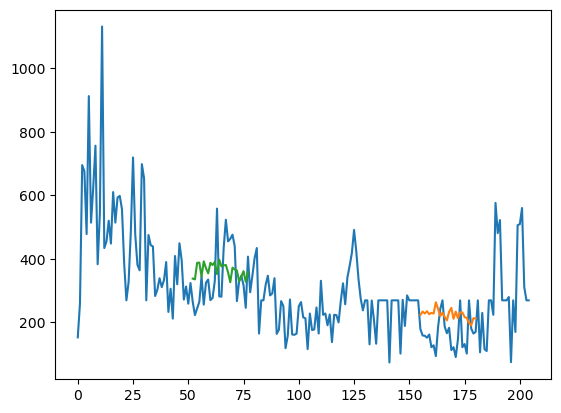

NEXT


In [448]:
if (not (productionMode) or True):
    for (idx, dataset) in enumerate(fullDataset) : 
        # print(dataset)
        forecastingDepthIndexToPlot = 0
        testPredictPlot = np.empty_like(dataset)
        testPredictPlot = [np.nan] * len(testPredictPlot)
        if (not (productionMode)):
            trainPredictPlot = np.empty_like(dataset)
            trainPredictPlot = [np.nan] * len(trainPredictPlot)
        #     print(len(TrainDatasetPredictions[idx][0]), len(trainPredictPlot))
            trainPredictPlot[timestamp:len(TrainDatasetPredictions[idx][0])+timestamp] = TrainDatasetPredictions[idx,0,:]
            testPredictPlot[len(TrainDatasetPredictions[idx][0])+(timestamp*2)+forecastingHorizon+forecastingDepthIndexToPlot-1:len(dataset)-1] = TestDatasetPredictions[idx,forecastingDepthIndexToPlot,:]
        else:
            testPredictPlot[timestamp+forecastingDepthIndexToPlot-1:len(dataset)-1] = TestDatasetPredictions[idx,forecastingDepthIndexToPlot,:]
        # print(len(TestDatasetPredictions[:,0]),len(trainPredict)+(timestamp*2)+1+forecastingHorizon, len(dataset)-1)
        print("DATASET INDEX ", idx)
        print("DATASET NUMBER ", datasetList[idx])
        plt.plot(dataset)
        plt.plot(testPredictPlot)
        if (not (productionMode)):
            plt.plot(trainPredictPlot)
        plt.show()
        print('NEXT')


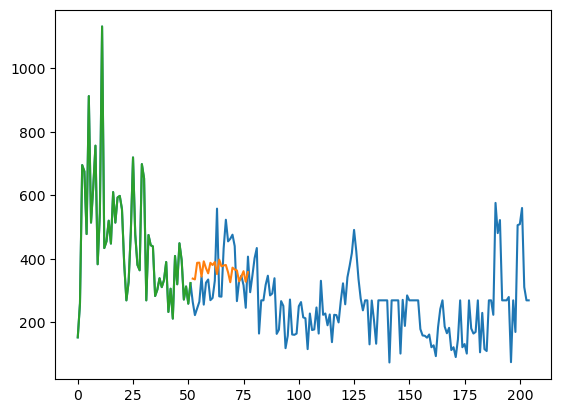

In [449]:
for (idx, dataset) in enumerate(fullDataset) : 
    if (not(progressiveForecast)):
        # for index in range (len(TrainDatasetPredictions[idx])):
        for index in range (1):

            individualTrainInputsPlot = np.empty_like(dataset)
            individualTrainInputsPlot = [np.nan] * len(individualTrainInputsPlot)
            individualTrainInputsPlot[index:timestamp+index] = TrainDatasetInputs[idx,index]

            individualTrainPredictPlot = np.empty_like(dataset)
            individualTrainPredictPlot = [np.nan] * len(individualTrainPredictPlot)
            individualTrainPredictPlot[index+timestamp:timestamp+index+forecastingHorizon] = TrainDatasetPredictions[idx,index]

            plt.plot(dataset)
            plt.plot(individualTrainPredictPlot)
            plt.plot(individualTrainInputsPlot)
            plt.show()

forecastingHorizon 26 indirectForecastingHorizon  26
417538
[nan, nan, nan, nan]
[nan, nan, nan, nan]


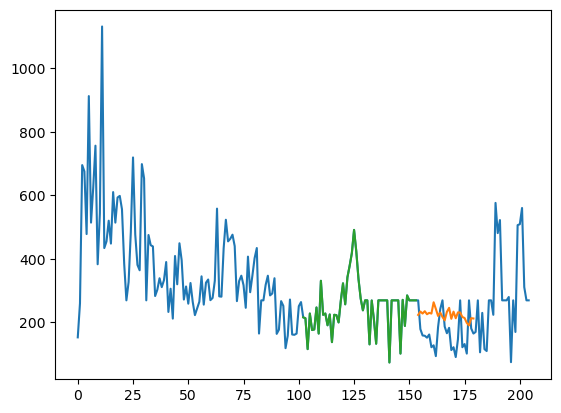

In [450]:

if (not (productionMode)):
    offset = 24
else:
    offset = 0
print("forecastingHorizon", forecastingHorizon, "indirectForecastingHorizon ", indirectForecastingHorizon)
for (idx, dataset) in enumerate(fullDataset) : 
    # print(TestDatasetPredictions[idx].shape)
    # for index in range (len(TestDatasetPredictions[idx])):
    for index in range (1):
        individualTestInputsPlot = np.empty_like(dataset)
        individualTestInputsPlot = [np.nan] * len(individualTestInputsPlot)

        individualTestPredictPlot = np.empty_like(dataset)
        individualTestPredictPlot = [np.nan] * len(individualTestPredictPlot)
        # print(len(TrainDatasetPredictions[idx][0]))
        print(datasetList[idx])
        if (not (productionMode)):
            individualTestInputsPlot[len(TrainDatasetPredictions[idx][0])+index+timestamp+offset:len(TrainDatasetPredictions[idx])+index+timestamp*2+offset-1] = TestDatasetInputs[idx,index]
            individualTestPredictPlot[len(TrainDatasetPredictions[idx][0])+index+timestamp*2+offset:len(TrainDatasetPredictions[idx])+index+2*timestamp+2*realForecastingHorizon-1+offset] = TestDatasetPredictions[idx,index]
        else:
            individualTestInputsPlot[index+offset:index+timestamp+offset-1] = TestDatasetInputs[idx,index]
            individualTestPredictPlot[index+timestamp+offset:index+timestamp+realForecastingHorizon-1+offset] = TestDatasetPredictions[idx,index]
        print(individualTestInputsPlot[50:54])
        print(individualTestPredictPlot[50:54])
        plt.plot(dataset)
        plt.plot(individualTestPredictPlot)
        plt.plot(individualTestInputsPlot)
        plt.show()



417538
205.793975830078


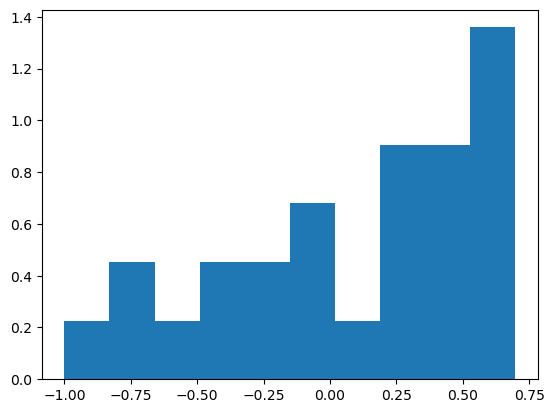

maxValue :  143.5076293945312  minValue :  -205.793975830078  rangeSize :  349.3016052246092  offset :  205.793975830078  mean :  19.2459787222056  variance :  99.14263422374937


In [451]:
if (not (productionMode)):
      for (idx, dataset) in enumerate(fullDataset) : 
            print(datasetList[idx])
            resolution = 10
            deltaE = TrainDatasetPredictions[idx,0,:] - TrainDatasetOutputs[idx,0,:]
            maxValue = max(deltaE)
            minValue = min(deltaE)
            rangeSize = (maxValue - minValue)
            mean = np.mean(deltaE)
            variance = np.std(deltaE, ddof=1) 
            # offset = rangeSize / 2 + minValue
            offset = max(maxValue,-minValue)
            print(offset)
            # offset = mean
            deltaE_with_Offset = [x/offset for x in deltaE]

            # count, bins, ignored = plt.hist(deltaE_with_Offset, resolution, density=True)
            count, bins, ignored = plt.hist(deltaE_with_Offset, resolution, density=True)
            # plt.plot(bins, 1/(variance * np.sqrt(2 * np.pi)) *
            #             np.exp( - (bins - mean)**2 / (2 * variance**2) ),
            #       linewidth=2, color='r')

            plt.show()
            print("maxValue : ", maxValue," minValue : ",minValue," rangeSize : ",rangeSize," offset : ",offset," mean : ",mean," variance : ",variance)

13


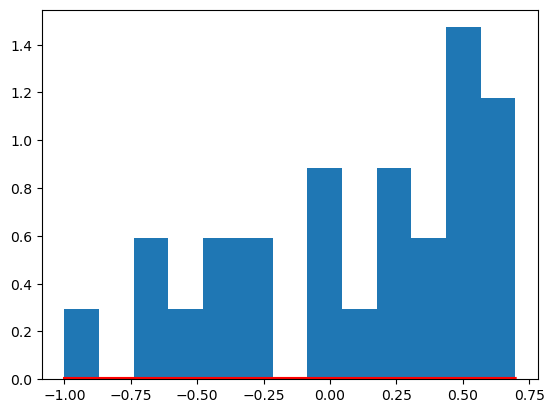

21


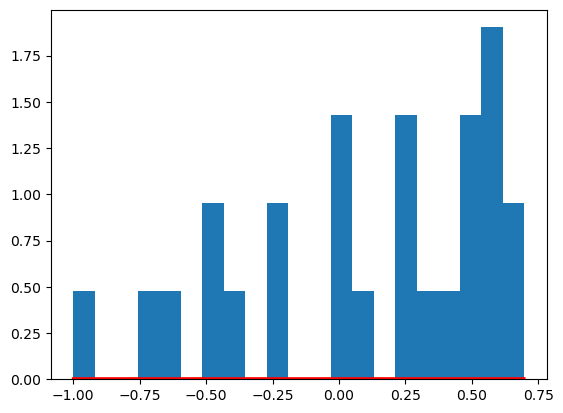

26


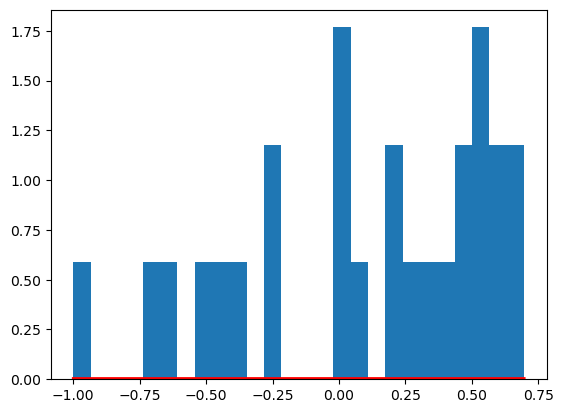

39


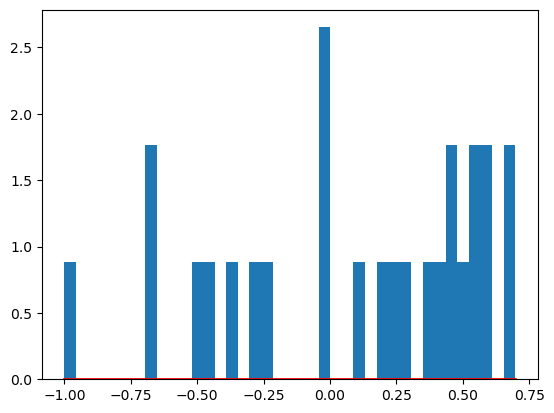

52


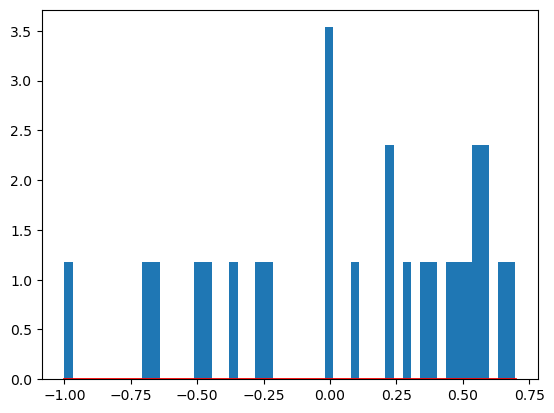

In [452]:
if (not (productionMode)):
    finalDelta = []
    ListofResolution = [13,21,26,39,52]
    for res in ListofResolution:
        print(res)
        for (idx, dataset) in enumerate(fullDataset) : 
            deltaE = TrainDatasetPredictions[idx,0,:] - TrainDatasetOutputs[idx,0,:]
            maxValue = max(deltaE)
            minValue = min(deltaE)
            rangeSize = (maxValue - minValue)
            mean = np.mean(deltaE)
            # variance = np.std(deltaE, ddof=1) 
            offset = max(maxValue,-minValue)
            # offset = mean
            sigma = math.sqrt(np.var(deltaE))
            # print(sigma)
            deltaE_with_Offset = [x / offset for x in deltaE]
            # deltaE_with_Offset_Normalized = [(x-mean)/sigma for x in deltaE_with_Offset]
            finalDelta.append(deltaE_with_Offset)
            # count, bins, ignored = plt.hist(deltaE_with_Offset, resolution, density=True)
            # print("maxValue : ", maxValue," minValue : ",minValue," rangeSize : ",rangeSize," offset : ",offset," mean : ",mean," variance : ",variance)
        count, bins, ignored = plt.hist(np.array(finalDelta).reshape(-1), res, density=True)
        plt.plot(bins, 1/(variance * np.sqrt(2 * np.pi)) *
                    np.exp( - (bins - mean)**2 / (2 * variance**2) ),
            linewidth=2, color='r')
        plt.show()



In [453]:
print(duration_bloc_1)
print(duration_bloc_2)
print(duration_bloc_3)
print(duration_bloc_4)
print(duration_bloc_5)
print(duration_bloc_6)
print(duration_bloc_7)
print(total_duration)

0.00392603874206543
0.0027310848236083984
0.01414179801940918
0.00019788742065429688
0.3985133171081543
0.07844090461730957
0.00787973403930664
0.5058307647705078


In [419]:
a = np.array([[[1, 2], [3, 4]]])
b = np.array([[[5, 6]]])
print(a.shape, b.shape)
np.concatenate((a, b), axis=1)

(1, 2, 2) (1, 1, 2)


array([[[1, 2],
        [3, 4],
        [5, 6]]])